In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import os, zipfile, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [3]:
ZIP_PATH = "/content/final.zip"
DATA_DIR = "/content/final_dataset/final/final/final"

if not os.path.exists(DATA_DIR):
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(DATA_DIR)
    print("Dataset extracted at:", DATA_DIR)
else:
    print("Using existing extracted dataset at:", DATA_DIR)


Using existing extracted dataset at: /content/final_dataset/final/final/final


In [4]:
# Load images
def load_images(data_dir, img_size=(150,150)):
    X, y = [], []
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    print("[INFO] Found classes:", class_names)
    for cls in class_names:
        folder = os.path.join(data_dir, cls)
        for img_name in os.listdir(folder):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(folder, img_name)
                img = image.load_img(path, target_size=img_size)
                arr = image.img_to_array(img)
                X.append(arr)
                y.append(cls)
    return np.array(X), np.array(y)

X_raw, y_raw = load_images(DATA_DIR)
print("Loaded:", X_raw.shape, "images")


[INFO] Found classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented', 'glioma', 'meningioma', 'pituitary']
Loaded: (9238, 150, 150, 3) images


In [5]:
#Extract features
base = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(150,150,3))
model = Model(inputs=base.input, outputs=base.output)
X_pp = preprocess_input(X_raw)
features = model.predict(X_pp, verbose=1)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
289/289 ━━━━━━━━━━━━━━━━━━━━ 148s 505ms/step


In [6]:
# Apply Label Encoding
le = LabelEncoder()
y_enc = le.fit_transform(y_raw)
X_train, X_test, y_train, y_test = train_test_split(features, y_enc, test_size=0.2, random_state=42, stratify=y_enc)


In [7]:
#Apply SMOTE
unique, counts = np.unique(y_train, return_counts=True)
print("\nBefore SMOTE:")
for c, n in zip(unique, counts):
    print(f"{le.classes_[c]}: {n}")

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

unique_res, counts_res = np.unique(y_res, return_counts=True)
print("\nAfter SMOTE:")
for c, n in zip(unique_res, counts_res):
    print(f"{le.classes_[c]}: {n}")



Before SMOTE:
MildDemented: 574
ModerateDemented: 42
NonDemented: 2048
VeryMildDemented: 1433
glioma: 1057
meningioma: 1071
pituitary: 1165

After SMOTE:
MildDemented: 2048
ModerateDemented: 2048
NonDemented: 2048
VeryMildDemented: 2048
glioma: 2048
meningioma: 2048
pituitary: 2048


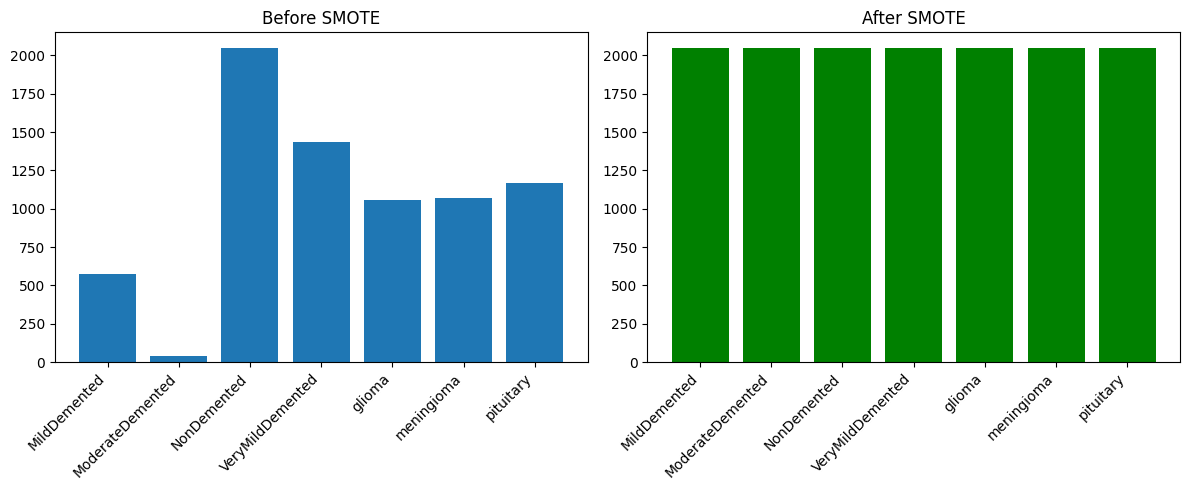


 SMOTE applied successfully on your final dataset.


In [8]:

#Plot Graph
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar([le.classes_[u] for u in unique], counts)
plt.title("Before SMOTE")
plt.xticks(rotation=45, ha='right')

plt.subplot(1,2,2)
plt.bar([le.classes_[u] for u in unique_res], counts_res, color='green')
plt.title("After SMOTE")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n SMOTE applied successfully on your final dataset.")

In [9]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

In [10]:
#TRAIN/TEST SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

num_classes = len(np.unique(y_res))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [11]:
#CNN MODEL
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

In [12]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5684 - loss: 1.0083 - val_accuracy: 0.7510 - val_loss: 0.5286
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7512 - loss: 0.5536 - val_accuracy: 0.7897 - val_loss: 0.4684
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7818 - loss: 0.4831 - val_accuracy: 0.8072 - val_loss: 0.4245
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8012 - loss: 0.4381 - val_accuracy: 0.8302 - val_loss: 0.3742
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8242 - loss: 0.3888 - val_accuracy: 0.8365 - val_loss: 0.3705
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8366 - loss: 0.3622 - val_accuracy: 0.8515 - val_loss: 0.3400
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8537 - loss: 0.3278 - val_accuracy: 0.8783 - val_loss: 0.2986
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8627 - loss: 0.3202 - val_accuracy: 0.

In [14]:
#EVALUATE
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n Test Accuracy: {acc*100:.2f}%")



 Test Accuracy: 92.75%


In [15]:
loss, acc = model.evaluate(X_train, y_train_cat, verbose=0)
print(f"\n Train Accuracy: {acc*100:.2f}%")


 Train Accuracy: 96.02%


In [16]:
# SAVE MODEL
model.save("model.h5")

In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

In [30]:
# Load trained classifier
model = tf.keras.models.load_model("/content/model.h5", compile=False)


In [31]:
# Load EfficientNet feature extractor (same as training)
base = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(150,150,3))

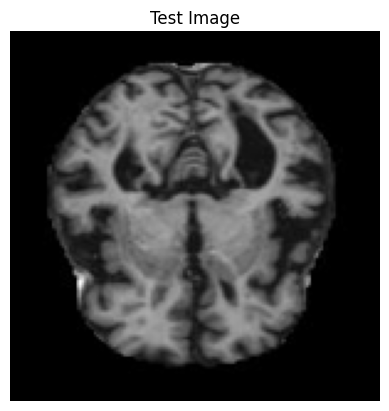

In [37]:
# Image path
img_path = "/content/mildDem0.jpg"

# Load and show image
img = Image.open(img_path).convert("RGB").resize((150,150))
plt.imshow(img)
plt.axis("off")
plt.title("Test Image")
plt.show()


In [33]:
# Convert to array and preprocess (for EfficientNet)
x = np.expand_dims(image.img_to_array(img), axis=0)
x = preprocess_input(x)


In [34]:
# Extract features (same step as training)
features = base.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [35]:
# Predict from classifier
pred = model.predict(features)
predicted_label = np.argmax(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [36]:
# Show result
print("Predicted Class:", le.classes_[predicted_label])

Predicted Class: MildDemented
